# Archival Novelty

This notebook explores whether requests to archive web resources using SavePageNow were the first time the Internet Archive became aware of a URL. Or rather, whether the request provided the Internet Archive with first knowledge of the web resource. Let's call this *archival novelty* which will be the percentage of SavePageNow requests which brought new knowledge of a URL to the Internet Archive. We are specifically going to look at *archival novelty* in terms of SavePageNow requests from automated and human agents.

The Internet Archive's [CDX API](https://github.com/internetarchive/wayback/tree/master/wayback-cdx-server) can tell us exactly when a given URL has been archived over time. But there are 7 million requests for HTML pages in our dataset. So what we will do is randomly sample the requests and check those against the CDX API.

First we will read in the URLS csv data that we generated in the URLs notebook back into a Spark DataFrame. Remember this only SavePageNow requests that resulted in an HTML responses, so it doesn't include things like images, JavaScript or CSS that SavePageNow could request when proxying an actual browser.

In [44]:
import sys
sys.path.append('../utils')

from warc_spark import init

sc, sqlc = init()
df = sqlc.read.csv('results/urls', header=True)

## Create Samples

Lets look specifically at 2018. Since millions of SavePageNow requests were received, and it's not feasible to query the CDX API millions of times, we will generate a random sample. Since we know the size of the population (number of requests) we will use the [Yamane Method](http://www.research-system.siam.edu/images/independent/Consumer_acceptance_of_air_purifier_products_in_China/CHAPTER_3.pdf) to calculate the sample size needed for a confidence interval of 5% and a confidence level of 95%.

In [45]:
import pandas

year = df.filter(df.date.like('2018%'))
pop_size = year.count()
sample_size = int(pop_size / (1 + pop_size * (.05**2)))
sample_list = year.rdd.takeSample(withReplacement=False, num=sample_size, seed=42)

print("sample size:", len(sample_list))

sample size: 399


In [46]:
print(sample_list[0])

Row(record_id='<urn:uuid:e70603a2-096a-4f82-b66d-7bc2bb5f286e>', warc_file='warcs/liveweb-20181025043139/live-20181025035248-wwwb-app53.us.archive.org.warc.gz', date='2018-10-25T04:12:23Z', url='http://eestipaevaleht.se/', user_agent='Python-urllib/2.7', user_agent_family='Python-urllib', bot='true')


In [47]:
sample = pandas.DataFrame(sample_list, columns=year.schema.fieldNames())
sample = sample.set_index('record_id')
sample.head()

,warc_file,date,url,user_agent,user_agent_family,bot
record_id,,,,,,
<urn:uuid:e70603a2-096a-4f82-b66d-7bc2bb5f286e>,warcs/liveweb-20181025043139/live-201810250352...,2018-10-25T04:12:23Z,http://eestipaevaleht.se/,Python-urllib/2.7,Python-urllib,true
<urn:uuid:8d3949bd-c7c4-45a1-b11f-90a0975de679>,warcs/liveweb-20181025212424/live-201810252105...,2018-10-25T21:23:14Z,http://km.aifb.kit.edu/projects/numbers/web/n2...,Wget/1.19.4 (darwin17.3.0),Wget,true
<urn:uuid:87c47520-05d9-47ac-b8b5-79408549caff>,warcs/liveweb-20181025170957/live-201810251658...,2018-10-25T17:05:13Z,https://socialblade.com/youtube/channel/UCCmXc...,Wget/1.19.5 (linux-gnu),Wget,true
<urn:uuid:0b7d69ca-d38c-4d6c-9f91-bcb63c82265c>,warcs/liveweb-20181025000937/cachegw-201810240...,2018-10-24T13:44:56Z,https://www.reg.ru/domain/shop/lot/rockderzhav...,Mozilla/5.0 (compatible; archive.org_bot; Wayb...,archive.org_bot,true
<urn:uuid:572b5006-3a51-43df-94fc-95ccfea727af>,warcs/liveweb-20181025165702/live-201810251631...,2018-10-25T16:47:20Z,http://abelhas.pt/action/LastAccounts/LastSeen...,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:63...,Firefox,false


## Add Novelty

Now let's create a function that will return all the times a URL was archived. If supplied the `to` parameter will limit the results to snapshots that were taken prior to (and including) that time. This will limit the results we need to collect since we don't really need to know how many times a URL was collected *after* the time in question.

In [48]:
import requests

def archive_times(url, to=None):
    params = {"output": "json", "url": url, "limit": 10000, 'showResumeKey': True}
    if to:
        params['to'] = to
    
    while True:
        resp = requests.get('http://web.archive.org/cdx/search/cdx', params=params)
        
        if resp.status_code == 403:
            # catch "Blocked Site Error" when robots.txt prevents lookup?
            # e.g. http://www.jeuxvideo.com/forums/42-51-53683620-1-0-1-0-pour-etre-assure-au-niveau-de-la-sante-aux-usa.htm 
            yield None
            break
            
        results = resp.json()
        # ignore header
        for result in results[1:]:
            if len(result) > 1:
                yield int(result[1])
        
        if len(results) != 0 and len(results[-1]) == 1:
            params['resumeKey'] = results[-1][0]
        else:
            break


print('https://mith.umd.edu', list(archive_times('https://mith.umd.edu/', to=20020929183602)))

https://mith.umd.edu [20000815201749, 20001204145800, 20010201091600, 20010203124200, 20010224212144, 20010301092808, 20010302112313, 20010309133144, 20010404212235, 20010418164605, 20010515215143, 20010721201430, 20010924024921, 20011202065537, 20020601134123, 20020604040017, 20020802093507, 20020927173901, 20020929183602]


Now that we have a function that returns all the times that a URL was archived we can create another function `new_url` that takes a uRL and a date and determines whether the snapshot taken at that time was the first time the URL was seen.

In [49]:
import re

def new_url(url, date):
    # convert 2018-10-25T21:47:18Z to 20181025214718
    request_date = int(re.sub(r'[:TZ-]', '', date))
    
    # cdx results should be sorted, but we'll make sure
    times = sorted(archive_times(url, to=request_date))
    if len(times) > 0:
        result = request_date == times[0]
    else:
        # sometimes it seems Wayback CDX doesn't know about things in the WARCs?
        # e.g. http://josephinedark.net/code.php?PHPSESSID=96bb60faa7f178b21b949e9359129459
        result = False
    
    return result

Let's test it out on the first ten rows in the humans sample:

In [52]:
for i, row in sample.head(5).iterrows():
    print(row.url, new_url(row.url, row.date))

http://eestipaevaleht.se/ False
http://km.aifb.kit.edu/projects/numbers/web/n2481513 True
https://socialblade.com/youtube/channel/UCCmXcYtA4T9wxc3vmbGFxRA False
https://www.reg.ru/domain/shop/lot/rockderzhava.ru?rid=2014 False
http://abelhas.pt/action/LastAccounts/LastSeenRotation?TimeStamp=1540485933469&itemsCount=84&inRow=7&pageSize=21&page=4 True


You can go over to [Internet Archive's Wayback Machine](https://web.archive.org) to confirm the results. Create a new column named `new_url` to indicate whether the URL was new when it was added to the Internet Archive. Depending on the number of rows in the sample this can take some time, since each row triggers a CDX API lookup, which will take about a second.

In [57]:
sample['new_url'] = pandas.Series(
    [new_url(r.url, r.date) for i, r in sample.iterrows()], 
    index=sample.index
)

In [58]:
sample.head(5)

,warc_file,date,url,user_agent,user_agent_family,bot,new_url
record_id,,,,,,,
<urn:uuid:e70603a2-096a-4f82-b66d-7bc2bb5f286e>,warcs/liveweb-20181025043139/live-201810250352...,2018-10-25T04:12:23Z,http://eestipaevaleht.se/,Python-urllib/2.7,Python-urllib,true,False
<urn:uuid:8d3949bd-c7c4-45a1-b11f-90a0975de679>,warcs/liveweb-20181025212424/live-201810252105...,2018-10-25T21:23:14Z,http://km.aifb.kit.edu/projects/numbers/web/n2...,Wget/1.19.4 (darwin17.3.0),Wget,true,True
<urn:uuid:87c47520-05d9-47ac-b8b5-79408549caff>,warcs/liveweb-20181025170957/live-201810251658...,2018-10-25T17:05:13Z,https://socialblade.com/youtube/channel/UCCmXc...,Wget/1.19.5 (linux-gnu),Wget,true,False
<urn:uuid:0b7d69ca-d38c-4d6c-9f91-bcb63c82265c>,warcs/liveweb-20181025000937/cachegw-201810240...,2018-10-24T13:44:56Z,https://www.reg.ru/domain/shop/lot/rockderzhav...,Mozilla/5.0 (compatible; archive.org_bot; Wayb...,archive.org_bot,true,False
<urn:uuid:572b5006-3a51-43df-94fc-95ccfea727af>,warcs/liveweb-20181025165702/live-201810251631...,2018-10-25T16:47:20Z,http://abelhas.pt/action/LastAccounts/LastSeen...,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:63...,Firefox,false,True


Now we can calcuate the novelty for 2018, or the probability that a SavePageNow request generated brought a new URL to the archive.

In [60]:
novelty = len(sample.query('new_url == True')) / len(sample)
print(novelty)

0.37343358395989973


So, 37% of SavePageNow requests on October 25, 2018 added a new (novel) URL to the archive. The margin of error is 5% with 95% level of confidence.

Let's save our sampled dataset since it did take some time to generate.

In [61]:
sample.to_csv('results/novelty-sample.csv')

## Automation and Archival Novelty

The User Agents notebook provides a general sense of whether traffic was automated or not. So it should be possible to see if there is any statistical difference in archival novelty between these two types of agents.

To do this we will run a [Chi-square Test for Association](https://en.wikipedia.org/wiki/Chi-squared_test). As our null-hypothesis we will assume that there is no difference in archival novelty between automated and human SavePageNow requests. If the null hypothesis can be rejected, then we must accept the alternate hypothesis that there is a difference in archival novelty between humans and bots.

If we we don't have it already load back the sample dataset that was created in the previous section.

In [1]:
import pandas

sample = pandas.read_csv('results/novelty-sample.csv', index_col='record_id')
sample.head()

,warc_file,date,url,user_agent,user_agent_family,bot,new_url
record_id,,,,,,,
<urn:uuid:e70603a2-096a-4f82-b66d-7bc2bb5f286e>,warcs/liveweb-20181025043139/live-201810250352...,2018-10-25T04:12:23Z,http://eestipaevaleht.se/,Python-urllib/2.7,Python-urllib,True,False
<urn:uuid:8d3949bd-c7c4-45a1-b11f-90a0975de679>,warcs/liveweb-20181025212424/live-201810252105...,2018-10-25T21:23:14Z,http://km.aifb.kit.edu/projects/numbers/web/n2...,Wget/1.19.4 (darwin17.3.0),Wget,True,True
<urn:uuid:87c47520-05d9-47ac-b8b5-79408549caff>,warcs/liveweb-20181025170957/live-201810251658...,2018-10-25T17:05:13Z,https://socialblade.com/youtube/channel/UCCmXc...,Wget/1.19.5 (linux-gnu),Wget,True,False
<urn:uuid:0b7d69ca-d38c-4d6c-9f91-bcb63c82265c>,warcs/liveweb-20181025000937/cachegw-201810240...,2018-10-24T13:44:56Z,https://www.reg.ru/domain/shop/lot/rockderzhav...,Mozilla/5.0 (compatible; archive.org_bot; Wayb...,archive.org_bot,True,False
<urn:uuid:572b5006-3a51-43df-94fc-95ccfea727af>,warcs/liveweb-20181025165702/live-201810251631...,2018-10-25T16:47:20Z,http://abelhas.pt/action/LastAccounts/LastSeen...,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:63...,Firefox,False,True


The next step is to obtain the relevant values for all the possible combinations of type of agent (bot or not) and novelty (new url or not).

In [2]:
values = []
values.append(len(sample.query('bot == True & new_url == True')))
values.append(len(sample.query('bot == False & new_url == True')))
values.append(len(sample.query('bot == True & new_url == False')))
values.append(len(sample.query('bot == False & new_url == False')))
print(values)

[91, 58, 195, 55]


I'm not sure why Jupyter centers tables by default, but we can change that...

In [3]:
%%html
<style>
table {float:left}
</style>

In tabular form this data would look like this:

| Novelty | Bots | Humans | Total |
|---------|------|--------|-------|
| New     | 91   | 58     | 149   |
| Not New | 195  | 55     | 250   |
| Total   | 286  | 113    | 399   |

Assuming that there is no relation between the type of agent (bot, human) and the novelty of the URL (new, not-new) it is possible to calculate the values we would expect to see based on the prevalance of those values in our sample. First we deteremine the percentages that the various variables have in our sample.

In [4]:
sample_size = len(sample)
p_bots = len(sample.query('bot == True')) / sample_size
p_humans = len(sample.query('bot == False')) / sample_size
p_new = len(sample.query('new_url == True')) / sample_size
p_not_new = len(sample.query('new_url == False')) / sample_size
print(p_bots, p_humans, p_new, p_not_new, sample_size)

0.7167919799498746 0.2832080200501253 0.37343358395989973 0.6265664160401002 399


Then we use these percentages and the sample size to calculate the values we would expect to see. Note: the order of these must match the ordering used in our values.

In [5]:
exp_values = []
exp_values.append(p_bots * p_new * sample_size)
exp_values.append(p_humans * p_new * sample_size)
exp_values.append(p_bots * p_not_new * sample_size)
exp_values.append(p_humans * p_not_new * sample_size)

print(exp_values)

[106.80200501253131, 42.19799498746867, 179.19799498746866, 70.80200501253132]


Now we can run our chi-square test courtesy of the scipy module.

In [6]:
import scipy.stats

scipy.stats.chisquare(values, exp_values, ddof=1)

Power_divergenceResult(statistic=13.175658317450203, pvalue=0.0013770260262489366)

Since the p-value is .0013, well below our significance level (.05), we can reject the null-hypothesis and accept our alternative hypothesis that the type of agent *is* related to the novelty of URLs. Again based on our sample size we can say this with a confidence level of 95% with a margin of error of 5%.

Let's look at the data visually to see what that relation might be. We can calcuate the percentage of each agents requests that resulted in new URLs being added to the Internet Archive.

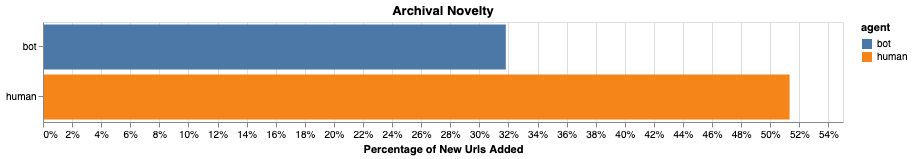

In [7]:
import altair
altair.renderers.enable('notebook')

novelty_df = pandas.DataFrame({
    'novelty': [
        len(sample.query('bot == True & new_url == True')) / len(sample.query('bot == True')),
        len(sample.query('bot == False & new_url == True')) / len(sample.query('bot == False'))
    ],
    'agent': ["bot", "human"]
})
                               
chart = altair.Chart(novelty_df).mark_bar().encode(
    altair.Y('agent:N', title=""),
    altair.X('novelty:Q', axis=altair.Axis(format='%', title="Percentage of New Urls Added")),
    altair.Color('agent:N')
)

chart = chart.properties(
    width=800,
    height=100,
    title='Archival Novelty'
)

chart

## What do the URLs look like?

While we can only look the novel URLs in our sample and not the entire data set it still could be useful to see them to get a sense of how they might be different.

In [90]:
bots = sample.query('bot == True & new_url == True')
for i, r in bots.iterrows():
    print(r.url)

http://km.aifb.kit.edu/projects/numbers/web/n2481513
http://km.aifb.kit.edu/projects/numbers/web/n2327119
http://www.virtualcinematography.org:80/log/jserr.php?msg=Uncaught+ReferenceError%3A+wbAutoComplete+is+not+defined&file=http%3A%2F%2Fweb.archive.org%2Fstatic%2Fjs%2Ftoolbar.js%3Fv%3D1538596186.0&line=209
http://www.aaaclipart.com/cgi-bin/imagefolio/imageFolio.cgi?action=view&link=tools&image=dustpan300.gif&img=63&tt=gif
http://km.aifb.kit.edu/projects/numbers/web/n2249709
http://km.aifb.kit.edu/projects/numbers/web/n2305494
http://www.geograph.org.uk/photo/1470929
http://km.aifb.kit.edu/projects/numbers/web/n2272483
http://km.aifb.kit.edu/projects/numbers/web/n2439183
https://www.bloomberg.com/tosv2.html?vid=&uuid=891be260-d841-11e8-9277-317c2271a489&url=L25ld3MvdmlkZW9zLzIwMTgtMTAtMjUvc2FldHJlLXdlaWdocy1zaGFyZS1idXliYWNrLWFzLWVxdWlub3ItYmVhdHMtZXN0aW1hdGVzLXZpZGVv
http://km.aifb.kit.edu/projects/numbers/web/n2310549
http://km.aifb.kit.edu/projects/numbers/web/n2172589
http://pagea

In [91]:
humans = sample.query('bot == False & new_url == True')
for i, r in humans.iterrows():
    print(r.url)

http://abelhas.pt/action/LastAccounts/LastSeenRotation?TimeStamp=1540485933469&itemsCount=84&inRow=7&pageSize=21&page=4
https://ameblo.jp/46292015/entry-12414331119.html
https://www.youtube.com/embed/SGi4j-bdcLk
https://mediacompaider.com/?wordfence_lh=1&hid=113194D9C466FBA698B788142F633407&r=0.9938724068405158
https://stackoverflow.com/questions/10615872/bootstrap-align-input-with-button?answertab=oldest
http://form.jotform.co/form/41331945693863
https://shared.uoit.ca/global/inc/get/emergencyfeed.php?_=1540481047469
https://web.archive.org/web/20070101000000*/https://forums.finalgear.com/forum/general-discussion/off-topic/29570-international-middleman-shipping
https://forums.nightfury.net/viewtopic.php?f=29&p=10028809
http://hello.distribeo.com/atconnect/c07c34aadeb1ec0eef081f88217a1d64d683e881?duration=300&lifetime=30&priority=1&rn=3858699218510308
https://stackoverflow.com/questions/23154525/django-generic-detail-view-must-be-called-with-either-an-object-pk-or-a-slug?answertab=acti

In [92]:
len(humans)

58

What are the hostnames in each?

In [93]:
from urllib.parse import urlparse
from collections import Counter

In [94]:
human_hostnames = Counter([urlparse(row.url).netloc for i, row in humans.iterrows()])
human_hostnames

Counter({'abelhas.pt': 2,
         'ameblo.jp': 2,
         'www.youtube.com': 2,
         'mediacompaider.com': 1,
         'stackoverflow.com': 5,
         'form.jotform.co': 1,
         'shared.uoit.ca': 1,
         'web.archive.org': 2,
         'forums.nightfury.net': 1,
         'hello.distribeo.com': 1,
         'www.google.com': 3,
         'payments.amazon.de': 1,
         'crypterium.io': 1,
         'www.twitch.tv': 1,
         'israblog.nana10.co.il': 1,
         'countus4.editeurjavascript.com': 1,
         'www.aaaclipart.com': 3,
         'myanimelist.net': 1,
         'www.epcotlegacy.com': 1,
         'www.pagerank-power.de': 1,
         'www.wykop.pl': 1,
         'pension-life.com': 1,
         'secure.adultddl.ws': 1,
         'www.holdtheline.com': 2,
         'www.systutorials.com': 1,
         'www.tumblr.com': 1,
         'www3.nhk.or.jp': 1,
         'trw12.com': 1,
         'pagead2.googlesyndication.com': 1,
         'www.gaccom.jp': 1,
         'github.com':

In [95]:
bot_hostnames = Counter([urlparse(row.url).netloc for i, row in bots.iterrows()])
bot_hostnames

Counter({'km.aifb.kit.edu': 59,
         'www.virtualcinematography.org:80': 1,
         'www.aaaclipart.com': 1,
         'www.geograph.org.uk': 4,
         'www.bloomberg.com': 1,
         'pagead2.googlesyndication.com': 1,
         'twitter.com': 12,
         'googleads.g.doubleclick.net': 2,
         'codereview.adblockplus.org': 2,
         'www.loc.gov': 1,
         'blocked.mts.ru': 1,
         'socialblade.com': 1,
         'www.lletrescatalanes.cat': 1,
         'www.icffr.org': 1,
         'tvtropes.org': 1,
         'ad.ettoday.net': 1,
         'lax1-ib.adnxs.com': 1})

See the Diversity notebook for more on this.

## Timetravel

We can also look to see whether the web pages were new from the perspective of [other web archives] than just the Internet Archive using the [timetravel.memntoweb.org](https://timetravel.mementoweb.org) API. This function will return True if a snapshot for a given URL is available before the supplied date, or False if it apperas to be new.

In [16]:
import re
import json
import time
import requests

def new_url_all(url, date, tries=1):
    date = re.sub(r'[TZ:-]', '', date)    
    print('checking {} for {}'.format(url, date))
    
    try:
        resp = requests.get('http://timetravel.mementoweb.org/api/json/{}/{}'.format(date, url))
    except json.JSONDecodeError as e:
        print('got JSON error: {}'.format(e))
        return False
    
    if resp.status_code != 200:
        print('{} error while fetching {} for {}'.format(resp.status_code, url, date))
        # 429 is the server telling us to slow down, so back off
        if resp.status_code == 429:
            sleep = tries * 2
            print('sleeping {}'.format(sleep))
            time.sleep(sleep)
            return new_url_all(url, date, tries+1) 
        return None
    
    results = resp.json()
    if 'mementos' in results and 'prev' in results['mementos']:
        return False
    else:
        return True

Let's test it out with two different dates one of which predates any known archive of this obscure website (it should be fast).

In [17]:
print(new_url_all('https://inkdroid.org/', '2013-06-04'))
print(new_url_all('https://inkdroid.org/', '2002-06-04'))

checking https://inkdroid.org/ for 20130604
False
checking https://inkdroid.org/ for 20020604
True


Try it again with a much more popular website (note the slow response times).

In [18]:
print(new_url_all('https://bbc.co.uk', '2018-01-01'))
print(new_url_all('https://bbc.co.uk', '1995-01-01'))

checking https://bbc.co.uk for 20180101
False
checking https://bbc.co.uk for 19950101
True


Now we can add add a new column `new_url_all` which indicates whether the URL 

In [19]:
sample['new_url_all'] = pandas.Series(
    [new_url_all(r.url, r.date) for i, r in sample.iterrows()], 
    index=sample.index
)

checking http://eestipaevaleht.se/ for 20181025041223
checking http://km.aifb.kit.edu/projects/numbers/web/n2481513 for 20181025212314
checking https://socialblade.com/youtube/channel/UCCmXcYtA4T9wxc3vmbGFxRA for 20181025170513
checking https://www.reg.ru/domain/shop/lot/rockderzhava.ru?rid=2014 for 20181024134456
checking http://abelhas.pt/action/LastAccounts/LastSeenRotation?TimeStamp=1540485933469&itemsCount=84&inRow=7&pageSize=21&page=4 for 20181025164720
checking https://www.youtube.com/channel/UCzIdYMdAtTsWucGCZyZvN6w/about for 20181025035706
checking https://www.alexa.com/siteinfo/udec.cl for 20181025224429
429 error while fetching https://www.alexa.com/siteinfo/udec.cl for 20181025224429
sleeping 2
checking https://www.alexa.com/siteinfo/udec.cl for 20181025224429
checking https://ameblo.jp/46292015/entry-12414331119.html for 20181025040111
checking https://a2ch.ru/2018/10/25/anon-a-esli-tak-vspomnit-svoiu-zhizn-a-est-li-u-tebia-podozreniia-imenno-185315009.html for 20181025180

429 error while fetching https://payments.amazon.de//gp/widgets/abtests?merchantId=xxxx&abtestName=NEW_WIDGETS&callback=jsonp1540455382365 for 20181025081705
sleeping 2
checking https://payments.amazon.de//gp/widgets/abtests?merchantId=xxxx&abtestName=NEW_WIDGETS&callback=jsonp1540455382365 for 20181025081705
429 error while fetching https://payments.amazon.de//gp/widgets/abtests?merchantId=xxxx&abtestName=NEW_WIDGETS&callback=jsonp1540455382365 for 20181025081705
sleeping 4
checking https://payments.amazon.de//gp/widgets/abtests?merchantId=xxxx&abtestName=NEW_WIDGETS&callback=jsonp1540455382365 for 20181025081705
429 error while fetching https://payments.amazon.de//gp/widgets/abtests?merchantId=xxxx&abtestName=NEW_WIDGETS&callback=jsonp1540455382365 for 20181025081705
sleeping 6
checking https://payments.amazon.de//gp/widgets/abtests?merchantId=xxxx&abtestName=NEW_WIDGETS&callback=jsonp1540455382365 for 20181025081705
429 error while fetching https://payments.amazon.de//gp/widgets/abt

checking http://pagead2.googlesyndication.com/pagead/ads?client=ca-primedia-basic_js&dt=1540477998419&hints=AfricanAmerican%20History%2CThe%20Montgomery%20Bus%20Boycott&adsafe=high&oe=latin1&num_ads=8&output=js&channel=primedia_afroamhistory&url=https%3A%2F%2Fweb.archive.org%2Fweb%2F20070305201140%2Fhttp%3A%2F%2Fafroamhistory.about.com%2Fod%2Fmontgomerybusboycott%2Fa%2Fmontbusboycott.htm&num_radlinks=5&max_radlink_len=20&loc=https%3A%2F%2Fweb.archive.org%2Fweb%2F20070305201140%2Fhttp%3A%2F%2Fafroamhistory.about.com%2Fod%2Fmontgomerybusboycott%2Fa%2Fmontbusboycott.htm&u_h=667&u_w=375&u_ah=667&u_aw=375&u_cd=32&u_tz=-240&u_his=6 for 20181025143319
429 error while fetching http://pagead2.googlesyndication.com/pagead/ads?client=ca-primedia-basic_js&dt=1540477998419&hints=AfricanAmerican%20History%2CThe%20Montgomery%20Bus%20Boycott&adsafe=high&oe=latin1&num_ads=8&output=js&channel=primedia_afroamhistory&url=https%3A%2F%2Fweb.archive.org%2Fweb%2F20070305201140%2Fhttp%3A%2F%2Fafroamhistory.abo

404 error while fetching http://pagead2.googlesyndication.com/pagead/ads?client=ca-primedia-basic_js&dt=1540477998419&hints=AfricanAmerican%20History%2CThe%20Montgomery%20Bus%20Boycott&adsafe=high&oe=latin1&num_ads=8&output=js&channel=primedia_afroamhistory&url=https%3A%2F%2Fweb.archive.org%2Fweb%2F20070305201140%2Fhttp%3A%2F%2Fafroamhistory.about.com%2Fod%2Fmontgomerybusboycott%2Fa%2Fmontbusboycott.htm&num_radlinks=5&max_radlink_len=20&loc=https%3A%2F%2Fweb.archive.org%2Fweb%2F20070305201140%2Fhttp%3A%2F%2Fafroamhistory.about.com%2Fod%2Fmontgomerybusboycott%2Fa%2Fmontbusboycott.htm&u_h=667&u_w=375&u_ah=667&u_aw=375&u_cd=32&u_tz=-240&u_his=6 for 20181025143319
checking http://km.aifb.kit.edu/projects/numbers/web/n2238263 for 20181025075134
429 error while fetching http://km.aifb.kit.edu/projects/numbers/web/n2238263 for 20181025075134
sleeping 2
checking http://km.aifb.kit.edu/projects/numbers/web/n2238263 for 20181025075134
checking https://www.youtube.com/channel/UC3JxYPRHnB5TvaCFuKf

429 error while fetching http://www.epcotlegacy.com/process/RecordHit?url=%2Fweb%2F20170211104028%2Fhttp%3A%2F%2Fwww.epcotlegacy.com%2Fmusic%2F&title=E82%20-%20The%20Epcot%20Legacy%20-%20Music&viewportInnerHeight=859&viewportInnerWidth=1665&screenHeight=1050&screenWidth=1680&userAgent=Mozilla%2F5.0%20(Macintosh%3B%20Intel%20Mac%20OS%20X%2010_14)%20AppleWebKit%2F605.1.15%20(KHTML%2C%20like%20Gecko)%20Version%2F12.0%20Safari%2F605.1.15&referrer=&pixelRatio=2&event=View for 20181025235140
sleeping 8
checking http://www.epcotlegacy.com/process/RecordHit?url=%2Fweb%2F20170211104028%2Fhttp%3A%2F%2Fwww.epcotlegacy.com%2Fmusic%2F&title=E82%20-%20The%20Epcot%20Legacy%20-%20Music&viewportInnerHeight=859&viewportInnerWidth=1665&screenHeight=1050&screenWidth=1680&userAgent=Mozilla%2F5.0%20(Macintosh%3B%20Intel%20Mac%20OS%20X%2010_14)%20AppleWebKit%2F605.1.15%20(KHTML%2C%20like%20Gecko)%20Version%2F12.0%20Safari%2F605.1.15&referrer=&pixelRatio=2&event=View for 20181025235140
429 error while fetchin

checking http://www.epcotlegacy.com/process/RecordHit?url=%2Fweb%2F20170211104028%2Fhttp%3A%2F%2Fwww.epcotlegacy.com%2Fmusic%2F&title=E82%20-%20The%20Epcot%20Legacy%20-%20Music&viewportInnerHeight=859&viewportInnerWidth=1665&screenHeight=1050&screenWidth=1680&userAgent=Mozilla%2F5.0%20(Macintosh%3B%20Intel%20Mac%20OS%20X%2010_14)%20AppleWebKit%2F605.1.15%20(KHTML%2C%20like%20Gecko)%20Version%2F12.0%20Safari%2F605.1.15&referrer=&pixelRatio=2&event=View for 20181025235140
429 error while fetching http://www.epcotlegacy.com/process/RecordHit?url=%2Fweb%2F20170211104028%2Fhttp%3A%2F%2Fwww.epcotlegacy.com%2Fmusic%2F&title=E82%20-%20The%20Epcot%20Legacy%20-%20Music&viewportInnerHeight=859&viewportInnerWidth=1665&screenHeight=1050&screenWidth=1680&userAgent=Mozilla%2F5.0%20(Macintosh%3B%20Intel%20Mac%20OS%20X%2010_14)%20AppleWebKit%2F605.1.15%20(KHTML%2C%20like%20Gecko)%20Version%2F12.0%20Safari%2F605.1.15&referrer=&pixelRatio=2&event=View for 20181025235140
sleeping 26
checking http://www.ep

429 error while fetching http://www.epcotlegacy.com/process/RecordHit?url=%2Fweb%2F20170211104028%2Fhttp%3A%2F%2Fwww.epcotlegacy.com%2Fmusic%2F&title=E82%20-%20The%20Epcot%20Legacy%20-%20Music&viewportInnerHeight=859&viewportInnerWidth=1665&screenHeight=1050&screenWidth=1680&userAgent=Mozilla%2F5.0%20(Macintosh%3B%20Intel%20Mac%20OS%20X%2010_14)%20AppleWebKit%2F605.1.15%20(KHTML%2C%20like%20Gecko)%20Version%2F12.0%20Safari%2F605.1.15&referrer=&pixelRatio=2&event=View for 20181025235140
sleeping 42
checking http://www.epcotlegacy.com/process/RecordHit?url=%2Fweb%2F20170211104028%2Fhttp%3A%2F%2Fwww.epcotlegacy.com%2Fmusic%2F&title=E82%20-%20The%20Epcot%20Legacy%20-%20Music&viewportInnerHeight=859&viewportInnerWidth=1665&screenHeight=1050&screenWidth=1680&userAgent=Mozilla%2F5.0%20(Macintosh%3B%20Intel%20Mac%20OS%20X%2010_14)%20AppleWebKit%2F605.1.15%20(KHTML%2C%20like%20Gecko)%20Version%2F12.0%20Safari%2F605.1.15&referrer=&pixelRatio=2&event=View for 20181025235140
429 error while fetchi

checking http://www.epcotlegacy.com/process/RecordHit?url=%2Fweb%2F20170211104028%2Fhttp%3A%2F%2Fwww.epcotlegacy.com%2Fmusic%2F&title=E82%20-%20The%20Epcot%20Legacy%20-%20Music&viewportInnerHeight=859&viewportInnerWidth=1665&screenHeight=1050&screenWidth=1680&userAgent=Mozilla%2F5.0%20(Macintosh%3B%20Intel%20Mac%20OS%20X%2010_14)%20AppleWebKit%2F605.1.15%20(KHTML%2C%20like%20Gecko)%20Version%2F12.0%20Safari%2F605.1.15&referrer=&pixelRatio=2&event=View for 20181025235140
429 error while fetching http://www.epcotlegacy.com/process/RecordHit?url=%2Fweb%2F20170211104028%2Fhttp%3A%2F%2Fwww.epcotlegacy.com%2Fmusic%2F&title=E82%20-%20The%20Epcot%20Legacy%20-%20Music&viewportInnerHeight=859&viewportInnerWidth=1665&screenHeight=1050&screenWidth=1680&userAgent=Mozilla%2F5.0%20(Macintosh%3B%20Intel%20Mac%20OS%20X%2010_14)%20AppleWebKit%2F605.1.15%20(KHTML%2C%20like%20Gecko)%20Version%2F12.0%20Safari%2F605.1.15&referrer=&pixelRatio=2&event=View for 20181025235140
sleeping 60
checking http://www.ep

checking http://enav-awse016-68.sbconline.teamaol.com/robots.txt for 20181024133244
checking http://mercury.bbspink.com/test/read.cgi/erobbs/1455644326 for 20181025053931
checking https://www.oanda.com/forex-trading/why/ for 20181025035356
checking https://stackoverflow.com/users for 20181025025650
checking http://www.geograph.org.uk/photo/1445777 for 20181025202744
checking https://www.tumblr.com/safe-mode?url=http%3A%2F%2Fcolormush.tumblr.com%2Fpost%2F179373344263 for 20181025014219
checking https://www.youtube.com/channel/UCzoUWqjCbcfWFdOMvoep8FA/videos?flow=list&sort=p&view=2 for 20181025035222
checking https://www.youtube.com/channel/UCf40kH47yvowumzzK9LVKKg/channels?flow=list for 20181025063343
checking https://www.youtube.com/channel/UCDAXusYwRJpiSP2CHnXnVnw for 20181025094053
checking http://km.aifb.kit.edu/projects/numbers/web/n2256199 for 20181025164838
429 error while fetching http://km.aifb.kit.edu/projects/numbers/web/n2256199 for 20181025164838
sleeping 2
checking http://

429 error while fetching https://googleads.g.doubleclick.net/pagead/ads?client=ca-pub-4270855877885521&output=html&h=90&slotname=4392198746&adk=3170063659&adf=1564918987&w=920&fwr_io=true&fwrn=4&fwrnh=100&lmt=1540365953&rafmt=1&guci=2.2.0.0.2.2.0&format=920x90&url=https%3A%2F%2Fyelospace.blogspot.com%2F2018%2F10%2Fawesome-god-you-are-so-good-by-sinach.html&flash=0&host=ca-host-pub-1556223355139109&h_ch=L0007&fwr=0&fwrattr=true&resp_fmts=3&wgl=1&adsid=NT&dt=1540374900338&bpp=22&bdt=261&fdt=30&idt=359&shv=r20181017&cbv=r20180604&saldr=aa&abxe=1&correlator=4126058762955&frm=20&pv=2&ga_vid=419467804.1540374901&ga_sid=1540374901&ga_hid=1658320591&ga_fc=0&iag=0&icsg=34080800&dssz=21&mdo=0&mso=0&u_tz=0&u_his=50&u_java=0&u_h=1000&u_w=1600&u_ah=1000&u_aw=1600&u_cd=24&u_nplug=2&u_nmime=2&adx=83&ady=2479&biw=1085&bih=784&scr_x=0&scr_y=0&eid=21060853%2C21070024&oid=3&rx=0&eae=0&fc=528&brdim=10%2C10%2C10%2C10%2C1600%2C0%2C1100%2C900%2C1100%2C784&vis=1&rsz=%7C%7CeoEbr%7C&abl=CS&ppjl=u&pfx=0&fu=144&b

429 error while fetching https://googleads.g.doubleclick.net/pagead/ads?client=ca-pub-4270855877885521&output=html&h=90&slotname=4392198746&adk=3170063659&adf=1564918987&w=920&fwr_io=true&fwrn=4&fwrnh=100&lmt=1540365953&rafmt=1&guci=2.2.0.0.2.2.0&format=920x90&url=https%3A%2F%2Fyelospace.blogspot.com%2F2018%2F10%2Fawesome-god-you-are-so-good-by-sinach.html&flash=0&host=ca-host-pub-1556223355139109&h_ch=L0007&fwr=0&fwrattr=true&resp_fmts=3&wgl=1&adsid=NT&dt=1540374900338&bpp=22&bdt=261&fdt=30&idt=359&shv=r20181017&cbv=r20180604&saldr=aa&abxe=1&correlator=4126058762955&frm=20&pv=2&ga_vid=419467804.1540374901&ga_sid=1540374901&ga_hid=1658320591&ga_fc=0&iag=0&icsg=34080800&dssz=21&mdo=0&mso=0&u_tz=0&u_his=50&u_java=0&u_h=1000&u_w=1600&u_ah=1000&u_aw=1600&u_cd=24&u_nplug=2&u_nmime=2&adx=83&ady=2479&biw=1085&bih=784&scr_x=0&scr_y=0&eid=21060853%2C21070024&oid=3&rx=0&eae=0&fc=528&brdim=10%2C10%2C10%2C10%2C1600%2C0%2C1100%2C900%2C1100%2C784&vis=1&rsz=%7C%7CeoEbr%7C&abl=CS&ppjl=u&pfx=0&fu=144&b

429 error while fetching https://googleads.g.doubleclick.net/pagead/ads?client=ca-pub-4270855877885521&output=html&h=90&slotname=4392198746&adk=3170063659&adf=1564918987&w=920&fwr_io=true&fwrn=4&fwrnh=100&lmt=1540365953&rafmt=1&guci=2.2.0.0.2.2.0&format=920x90&url=https%3A%2F%2Fyelospace.blogspot.com%2F2018%2F10%2Fawesome-god-you-are-so-good-by-sinach.html&flash=0&host=ca-host-pub-1556223355139109&h_ch=L0007&fwr=0&fwrattr=true&resp_fmts=3&wgl=1&adsid=NT&dt=1540374900338&bpp=22&bdt=261&fdt=30&idt=359&shv=r20181017&cbv=r20180604&saldr=aa&abxe=1&correlator=4126058762955&frm=20&pv=2&ga_vid=419467804.1540374901&ga_sid=1540374901&ga_hid=1658320591&ga_fc=0&iag=0&icsg=34080800&dssz=21&mdo=0&mso=0&u_tz=0&u_his=50&u_java=0&u_h=1000&u_w=1600&u_ah=1000&u_aw=1600&u_cd=24&u_nplug=2&u_nmime=2&adx=83&ady=2479&biw=1085&bih=784&scr_x=0&scr_y=0&eid=21060853%2C21070024&oid=3&rx=0&eae=0&fc=528&brdim=10%2C10%2C10%2C10%2C1600%2C0%2C1100%2C900%2C1100%2C784&vis=1&rsz=%7C%7CeoEbr%7C&abl=CS&ppjl=u&pfx=0&fu=144&b

429 error while fetching https://googleads.g.doubleclick.net/pagead/ads?client=ca-pub-4270855877885521&output=html&h=90&slotname=4392198746&adk=3170063659&adf=1564918987&w=920&fwr_io=true&fwrn=4&fwrnh=100&lmt=1540365953&rafmt=1&guci=2.2.0.0.2.2.0&format=920x90&url=https%3A%2F%2Fyelospace.blogspot.com%2F2018%2F10%2Fawesome-god-you-are-so-good-by-sinach.html&flash=0&host=ca-host-pub-1556223355139109&h_ch=L0007&fwr=0&fwrattr=true&resp_fmts=3&wgl=1&adsid=NT&dt=1540374900338&bpp=22&bdt=261&fdt=30&idt=359&shv=r20181017&cbv=r20180604&saldr=aa&abxe=1&correlator=4126058762955&frm=20&pv=2&ga_vid=419467804.1540374901&ga_sid=1540374901&ga_hid=1658320591&ga_fc=0&iag=0&icsg=34080800&dssz=21&mdo=0&mso=0&u_tz=0&u_his=50&u_java=0&u_h=1000&u_w=1600&u_ah=1000&u_aw=1600&u_cd=24&u_nplug=2&u_nmime=2&adx=83&ady=2479&biw=1085&bih=784&scr_x=0&scr_y=0&eid=21060853%2C21070024&oid=3&rx=0&eae=0&fc=528&brdim=10%2C10%2C10%2C10%2C1600%2C0%2C1100%2C900%2C1100%2C784&vis=1&rsz=%7C%7CeoEbr%7C&abl=CS&ppjl=u&pfx=0&fu=144&b

404 error while fetching https://googleads.g.doubleclick.net/pagead/ads?client=ca-pub-4270855877885521&output=html&h=90&slotname=4392198746&adk=3170063659&adf=1564918987&w=920&fwr_io=true&fwrn=4&fwrnh=100&lmt=1540365953&rafmt=1&guci=2.2.0.0.2.2.0&format=920x90&url=https%3A%2F%2Fyelospace.blogspot.com%2F2018%2F10%2Fawesome-god-you-are-so-good-by-sinach.html&flash=0&host=ca-host-pub-1556223355139109&h_ch=L0007&fwr=0&fwrattr=true&resp_fmts=3&wgl=1&adsid=NT&dt=1540374900338&bpp=22&bdt=261&fdt=30&idt=359&shv=r20181017&cbv=r20180604&saldr=aa&abxe=1&correlator=4126058762955&frm=20&pv=2&ga_vid=419467804.1540374901&ga_sid=1540374901&ga_hid=1658320591&ga_fc=0&iag=0&icsg=34080800&dssz=21&mdo=0&mso=0&u_tz=0&u_his=50&u_java=0&u_h=1000&u_w=1600&u_ah=1000&u_aw=1600&u_cd=24&u_nplug=2&u_nmime=2&adx=83&ady=2479&biw=1085&bih=784&scr_x=0&scr_y=0&eid=21060853%2C21070024&oid=3&rx=0&eae=0&fc=528&brdim=10%2C10%2C10%2C10%2C1600%2C0%2C1100%2C900%2C1100%2C784&vis=1&rsz=%7C%7CeoEbr%7C&abl=CS&ppjl=u&pfx=0&fu=144&b

checking https://web.archive.org/web/20181025092804/https://twitter.com/alanmayers/status/1034091370124902400/?lang=th for 20181025093035
checking https://www.youtube.com/channel/UCYcdw2wL6W6iGBKZgGK_Hjw/videos?flow=list&sort=da&view=2 for 20181025164532
checking http://mobile-18.sbconline.teamaol.com/robots.txt for 20181024133603
checking https://www.youtube.com/channel/UCax9CJCQ6aY0bntP3mcIWKQ/community for 20181025004843
checking https://streamable.com/xo2t2 for 20181025131825
checking https://www.youtube.com/channel/UCOq_WLazgC7IZo9NzXSmInw/community for 20181025040016
checking https://developer.mozilla.org/fr/docs/Mozilla/Add-ons/Distribution/Submitting_an_add-on for 20181025123818
checking https://www.youtube.com/channel/UCKlhpmbHGxBE6uw9B_uLeqQ/videos?flow=list&sort=p&view=0 for 20181025214940
checking http://enav-awse2-56.sbconline.teamaol.com/robots.txt for 20181024133253
checking http://km.aifb.kit.edu/projects/numbers/web/n2424528 for 20181025185328
checking http://km.aifb.k

checking http://ad.ettoday.net/ads.php?bid=mobileweb_320x50_bottom2&rr=0.31280040374807416 for 20181025114420
checking https://www.youtube.com/channel/UC0D4TPONTJ6cppMxQ9SD97g for 20181025003244
checking http://km.aifb.kit.edu/projects/numbers/web/n2284143 for 20181025095734
checking https://suumo.jp/tochi/kanagawa/sc_ashigarashimogun/nc_90560413/ for 20181025063334
checking https://www.youtube.com/channel/UCzFUs-fmDxTSIoaWYeFFyOA/channels?flow=list for 20181025010504
checking http://km.aifb.kit.edu/projects/numbers/web/n2455768 for 20181025202447
checking http://km.aifb.kit.edu/projects/numbers/web/n2128893 for 20181025024843
checking https://www.cbsnews.com/ for 20181025144145
checking https://developer.mozilla.org/ja/docs/Web/JavaScript/Reference/Operators/Legacy_generator_function for 20181025114727
checking http://km.aifb.kit.edu/projects/numbers/web/n2079928 for 20181025003252
checking https://euw.merch.riotgames.com/en/ for 20181024070047
checking https://www.youtube.com/channel

429 error while fetching https://www.cityheaven.net/ibaraki/A0801/A080101/club-opus/girlid-23121672/diary/pd-260227085/ for 20181025110606
sleeping 10
checking https://www.cityheaven.net/ibaraki/A0801/A080101/club-opus/girlid-23121672/diary/pd-260227085/ for 20181025110606
403 error while fetching https://www.cityheaven.net/ibaraki/A0801/A080101/club-opus/girlid-23121672/diary/pd-260227085/ for 20181025110606
checking https://www.youtube.com/channel/UCIg56SgvoZF8Qg0Jx_gh6Pg for 20181025034440
checking https://www.alexa.com/siteinfo/gentside-news.fr for 20181025172143
checking https://www.youtube.com/channel/UCzoseYCCso1yJPPApnTHM1g/playlists?flow=list&view=1&sort=lad for 20181025160146
checking https://socialblade.com/youtube/channel/UCFOSg71CRAJ58IPuV_-jMbw for 20181025164931
checking https://www.youtube.com/channel/UCR_Te2bbmsrqvYlAmkgA2sA/about for 20181025095016
checking https://rpg.stackexchange.com/questions/134208/what-is-the-difference-between-giving-advantage-on-a-roll-and-red

In [22]:
sample.head(10)

,warc_file,date,url,user_agent,user_agent_family,bot,new_url,new_url_all
record_id,,,,,,,,
<urn:uuid:e70603a2-096a-4f82-b66d-7bc2bb5f286e>,warcs/liveweb-20181025043139/live-201810250352...,2018-10-25T04:12:23Z,http://eestipaevaleht.se/,Python-urllib/2.7,Python-urllib,True,False,False
<urn:uuid:8d3949bd-c7c4-45a1-b11f-90a0975de679>,warcs/liveweb-20181025212424/live-201810252105...,2018-10-25T21:23:14Z,http://km.aifb.kit.edu/projects/numbers/web/n2...,Wget/1.19.4 (darwin17.3.0),Wget,True,True,True
<urn:uuid:87c47520-05d9-47ac-b8b5-79408549caff>,warcs/liveweb-20181025170957/live-201810251658...,2018-10-25T17:05:13Z,https://socialblade.com/youtube/channel/UCCmXc...,Wget/1.19.5 (linux-gnu),Wget,True,False,False
<urn:uuid:0b7d69ca-d38c-4d6c-9f91-bcb63c82265c>,warcs/liveweb-20181025000937/cachegw-201810240...,2018-10-24T13:44:56Z,https://www.reg.ru/domain/shop/lot/rockderzhav...,Mozilla/5.0 (compatible; archive.org_bot; Wayb...,archive.org_bot,True,False,False
<urn:uuid:572b5006-3a51-43df-94fc-95ccfea727af>,warcs/liveweb-20181025165702/live-201810251631...,2018-10-25T16:47:20Z,http://abelhas.pt/action/LastAccounts/LastSeen...,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:63...,Firefox,False,True,True
<urn:uuid:68566662-0e3b-46cd-b941-fc6d8604830b>,warcs/liveweb-20181025034513/live-201810250332...,2018-10-25T03:57:06Z,https://www.youtube.com/channel/UCzIdYMdAtTsWu...,Wget/1.19.5 (linux-gnu),Wget,True,False,False
<urn:uuid:43a1f7de-c241-4554-adfd-412baea61ef6>,warcs/liveweb-20181025224655/live-201810252148...,2018-10-25T22:44:29Z,https://www.alexa.com/siteinfo/udec.cl,Wget/1.19.5 (linux-gnu),Wget,True,False,False
<urn:uuid:e6bbd509-36e9-4a87-91a9-a1ac6b15726a>,warcs/liveweb-20181025043139/live-201810250352...,2018-10-25T04:01:11Z,https://ameblo.jp/46292015/entry-12414331119.html,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,Chrome,False,True,True
<urn:uuid:23905a4c-0b6b-428b-b1f8-3762cdbe55d3>,warcs/liveweb-20181025181921/live-201810251805...,2018-10-25T18:09:59Z,https://a2ch.ru/2018/10/25/anon-a-esli-tak-vsp...,Mozilla/5.0 (compatible; archive.org_bot; Wayb...,archive.org_bot,True,False,True


In [23]:
sample.to_csv('results/novelty-sample.csv')

In [31]:
not_ia = sample.query('new_url == False and new_url_all == True')
for id, row in not_ia.iterrows():
    print(row['date'], row['url'])

2018-10-25T18:09:59Z https://a2ch.ru/2018/10/25/anon-a-esli-tak-vspomnit-svoiu-zhizn-a-est-li-u-tebia-podozreniia-imenno-185315009.html
2018-10-25T01:10:38Z http://www.bt.se/tt-ekonomi/krafitgt-fall-pa-japans-bors/
2018-10-25T23:44:22Z https://twitter.com/meraktepe1/status/1055603817465688064
2018-10-25T14:10:41Z https://docs.djangoproject.com/id/2.1/ref/request-response/
2018-10-25T04:28:12Z https://ssl2.excite.co.jp/idc/login/?si=blog&ru=http://aishoren.exblog.jp/page/22/
2018-10-25T05:25:16Z https://www.dalademokraten.se/artikel/opinion/debatt/insandare-lat-oss-fula-forenas-i-det-femte-och-sista-dalaupproret
2018-10-25T22:42:19Z https://tvtropes.org/pmwiki/pmwiki.php/VideoGame/Osada?cloudflare=clusterfuck
2018-10-25T21:46:03Z https://www.facebook.com/plugins/like.php?href=http%3A%2F%2Fwonkette.com%2F474165%2Foklahoma-congressional-candidate-vows-war-on-texas-if-elected&layout=button_count&show_faces=false&width=105&action=like&font=arial&colorscheme=light
2018-10-25T03:49:52Z https:

In [25]:
print()

399